In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from scipy import stats
from combat.pycombat import pycombat
import umap
from collections import Counter

In [2]:
met_raw_df = pd.read_csv('../data/data_zscore_comp_id.csv')
met_raw_df.set_index(met_raw_df.columns[0], inplace=True)
met_raw_df

,BAYL-08997,BAYL-08998,BAYL-08999,BAYL-09000,BAYL-09001,BAYL-09002,BAYL-09003,BAYL-09004,BAYL-09005,BAYL-09006,...,s_21944,s_22832,s_22842,s_22997,s_23003,s_23077,s_23123,s_22787,s_23294,s_73385
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
42370,-1.259948,0.170557,0.814204,0.038958,-0.504466,-0.757901,-0.986865,0.993000,0.986541,0.000250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,-0.610334,-0.811169,-0.554787,-0.603603,-0.549375,-0.631363,0.606882,1.238204,1.661840,-0.931552,...,-0.434904,-0.730548,-0.009508,-0.607362,0.219333,-0.767359,-0.421440,0.085019,-0.732586,-1.167603
27665,-1.201809,0.387317,-1.062940,0.525122,-0.973446,-0.253533,0.195547,0.769406,0.796718,-0.058625,...,0.825309,2.224161,0.182297,-0.697035,0.161942,-0.266286,0.775185,-0.640354,1.440073,0.458074
38395,-0.954275,-0.906589,4.929942,0.974496,-0.740805,0.642705,-0.293678,0.650630,1.008092,-0.778676,...,-1.505053,-1.112171,0.062801,-0.778621,0.574785,-0.251823,-0.822022,-1.332230,0.767016,-1.741468
437,0.240999,-0.454249,-0.000406,-0.542391,NaN,0.403722,-0.492163,0.252810,-0.517825,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
met_names_df = pd.read_excel('../data/BAYL-04-22MD+ Data Tables Updated.xlsx', sheet_name='Chemical Annotation')
met_names_df = met_names_df.loc[:, ['COMP_ID', 'CHEMICAL_NAME']].sort_values('COMP_ID')  # CHEMICAL_NAME
met_names_df.set_index('COMP_ID', inplace=True)
met_names_df.head()

,CHEMICAL_NAME
COMP_ID,
53,glutamine
54,tryptophan
55,beta-alanine
56,cystine
57,glutamate


In [4]:
clin_df = pd.read_csv('../data/sampleAttr.csv', index_col=0)
# clin_df.loc[:, 'Aspirin'] = clin_df['ASA_tri_chr'].apply(lambda x: 0 if 'PLACEBO' in x else 1)
# clin_df.loc[:, 'Trimester'] = clin_df['ASA_tri_chr'].apply(lambda x: int(x[-13]))
# clin_df = clin_df[['trimester', 'ASA', 'pe']]
clin_df

,age,pe,race,consss_batch,ASA_tri_chr,weight,BErm,sle,ga.w,height,ptIDs,Compliance,conception,crl,smoking,STUDY,prev.pe,ASA,trimester
sIDs,,,,,,,,,,,,,,,,,,,
BAYL-08997,36.64887063655031,1.0,Chinese,batch-2023,ASA - 1st Trimester,45.1,batch_2023,0,NaN,150,S1_1_Ca,94.444444,7,55.3,0,CHUK,7,True,1
BAYL-08998,32.309377138945926,1.0,Chinese,batch-2023,ASA - 1st Trimester,82.2,batch_2023,0,NaN,171,S1_2_Ca,94.267516,7,63.1,0,CHUK,2,True,1
BAYL-08999,43.90143737166324,0.0,Chinese,batch-2023,ASA - 1st Trimester,69.6,batch_2023,0,NaN,161,S1_1_Co,99.367089,7,58.8,0,CHUK,7,True,1
BAYL-09000,33.11430527036276,0.0,Chinese,batch-2023,ASA - 1st Trimester,51.4,batch_2023,0,NaN,154,S1_2_Co,98.684211,7,62.9,0,CHUK,7,True,1
BAYL-09001,24.32032854209445,0.0,Chinese,batch-2023,ASA - 1st Trimester,39.2,batch_2023,0,NaN,161,S1_4_Co,95.597484,7,45.3,0,CHUK,7,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,33.8562628336756,0.0,Black,batch-2021,PLACEBO - 2nd Trimester,71.0,batch_2021,No,NaN,162.0,pt_755998,0.000000,Spontaneous,60.2,No,from-2015,Multip-no PE,False,2
s_23123,25.3141683778234,0.0,Black,batch-2021,PLACEBO - 2nd Trimester,58.1,batch_2021,No,NaN,155.0,pt_727062,0.000000,Spontaneous,53.6,No,from-2015,Nullip,False,2
s_22787,29.7659137577002,0.0,Black,batch-2021,PLACEBO - 2nd Trimester,93.8,batch_2021,No,NaN,163.0,pt_20889,0.000000,Spontaneous,59.3,No,from-2015,Multip-no PE,False,2


# Merge and preprocess data

In [14]:
met_df = met_raw_df.merge(met_names_df, left_index=True, right_index=True)
met_df.set_index('CHEMICAL_NAME', inplace=True)
met_df = met_df.T
# met_df.loc[:, 'pe'] = clin_df['pe']
# met_df = met_df[clin_df['trimester'] == 3]
print(f'Initial number of metabolites: {met_df.shape[1]}')
met_df = met_df.loc[:, met_df.isnull().sum() < 0.2*met_df.shape[0]]  # Fill rate > 80%
print(f'Number of metabolites after Fill rate > 80% filter: {met_df.shape[1]}')
met_df = met_df[list(filter(lambda x: 'x' not in x.lower(), met_df.columns))]
print(f'Number of metabolites after removing X-molecules: {met_df.shape[1]}')
met_df = met_df.fillna(met_df.min())
met_df

Initial number of metabolites: 968
Number of metabolites after Fill rate > 80% filter: 745
Number of metabolites after removing X-molecules: 528


CHEMICAL_NAME,spermidine,1-methylnicotinamide,"12,13-DiHOME",alpha-ketoglutarate,kynurenate,3-phosphoglycerate,cholate,"5,6-dihydrothymine","9,10-DiHOME",linoleate (18:2n6),...,glyco-beta-muricholate**,glycine conjugate of C10H14O2 (1)*,"sphingomyelin (d17:1/14:0, d16:1/15:0)*",6-bromotryptophan,dodecadienoate (12:2)*,N-acetyl-isoputreanine,sulfate of piperine metabolite C16H19NO3 (2)*,sulfate of piperine metabolite C16H19NO3 (3)*,sulfate of piperine metabolite C18H21NO3 (1)*,sulfate of piperine metabolite C18H21NO3 (3)*
BAYL-08997,-0.610334,-1.201809,-0.954275,-0.485987,0.598959,-0.660514,-0.355321,-0.898309,-0.667690,-0.874199,...,-0.299662,-0.939114,-0.838303,-1.399022,-0.656606,-1.702764,-0.884692,-0.810793,-0.770932,-0.683563
BAYL-08998,-0.811169,0.387317,-0.906589,-0.409053,0.612680,0.001887,-0.108802,-0.111114,-0.696468,-0.820280,...,0.156296,-0.396659,-0.697519,0.887825,-1.112439,-0.969079,-0.466641,-0.426476,-0.438533,-0.397876
BAYL-08999,-0.554787,-1.062940,4.929942,0.022588,3.050217,-0.142467,-0.215959,-0.479178,2.368797,1.660334,...,-0.390418,0.851302,-0.742232,-0.390750,0.301971,-0.991800,-0.514876,-0.396405,-0.244924,0.445289
BAYL-09000,-0.603603,0.525122,0.974496,-0.494779,-0.347355,-0.359097,-0.335079,-0.369941,0.309919,-0.618017,...,0.233752,-0.487078,-0.952760,1.479042,-0.445710,-0.805737,-0.781056,-0.756450,-0.922030,-0.847816
BAYL-09001,-0.549375,-0.973446,-0.740805,-0.049422,-0.787278,-0.515097,-0.176998,4.681018,-0.627905,0.940678,...,-0.613016,1.260862,-0.534981,0.603498,1.521883,-0.866545,0.272540,0.212023,-0.165409,0.366029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-0.767359,-0.266286,-0.251823,0.162015,-2.564631,-0.809305,-0.028283,-0.336513,-0.733505,-1.243590,...,-0.565849,-0.756449,1.115718,-1.628595,-3.419015,-0.335398,1.051963,0.962210,1.060235,0.956444
s_23123,-0.421440,0.775185,-0.822022,-0.091252,-1.624241,-0.779540,-0.168885,-1.447742,-0.977625,-1.101853,...,-0.180182,-1.007543,0.400393,-1.121863,-1.153469,-0.352297,0.283153,0.157192,0.443618,0.300457
s_22787,0.085019,-0.640354,-1.332230,0.534896,-2.285493,-0.649324,0.127443,-0.342412,-2.082006,-1.367824,...,-1.732258,-0.008867,-0.175965,-1.298844,-2.070522,0.141490,0.469147,0.512265,0.648034,0.539695
s_23294,-0.732586,1.440073,0.767016,-0.599035,-1.277730,-1.076107,-2.074105,-0.264915,1.019940,-0.965180,...,-0.625664,-1.569176,1.376506,0.067642,-1.343205,-0.396227,1.435338,1.397590,1.336402,1.233001


# Remove batch effects

In [15]:
clin_df.loc[:, 'STUDY'] = clin_df.loc[:, 'STUDY'].apply(lambda x: x.replace('from-2015', 'previous study'))
batches = list(clin_df['STUDY'].unique())
batches_dict = {k: v for v, k in enumerate(batches)}
umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(met_df)

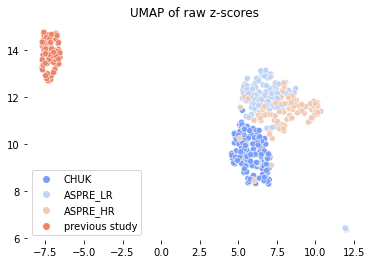

In [16]:
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=clin_df['STUDY'].apply(lambda x: batches[batches_dict[x]]).values, palette='coolwarm')
plt.title('UMAP of raw z-scores')
plt.box(False)
plt.savefig('umap_before_batch.png', dpi=250, bbox_inches='tight')
plt.show()

In [17]:
met_df_corrected = pycombat(met_df.T, clin_df['STUDY'].values).T

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


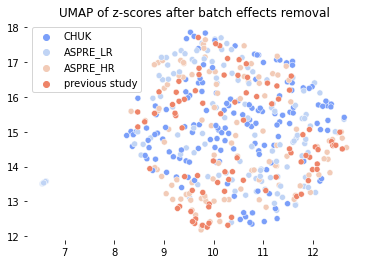

In [18]:
umap_result_corrected = umap_model.fit_transform(met_df_corrected)
sns.scatterplot(x=umap_result_corrected[:, 0], y=umap_result_corrected[:, 1], hue=clin_df['STUDY'].apply(lambda x: batches[batches_dict[x]]).values, palette='coolwarm')
plt.title('UMAP of z-scores after batch effects removal')
plt.box(False)
plt.savefig('umap_after_batch.png', dpi=250)
plt.show()
plt.show()

In [75]:
outliers = set(clin_df.iloc[umap_result_corrected[:, 0] < 7, :].index)  # Check UMAP then set threshold
met_df_corr_filt = met_df_corrected[~met_df_corrected.index.isin(outliers)].copy()
met_df_corr_filt.loc[:, 'pe'] = clin_df['pe']
clin_filt_df = clin_df[~clin_df.index.isin(outliers)]
met_df_corr_filt.shape

(456, 529)

In [20]:
met_df_corr_filt

CHEMICAL_NAME,spermidine,1-methylnicotinamide,"12,13-DiHOME",alpha-ketoglutarate,kynurenate,3-phosphoglycerate,cholate,"5,6-dihydrothymine","9,10-DiHOME",linoleate (18:2n6),...,glycine conjugate of C10H14O2 (1)*,"sphingomyelin (d17:1/14:0, d16:1/15:0)*",6-bromotryptophan,dodecadienoate (12:2)*,N-acetyl-isoputreanine,sulfate of piperine metabolite C16H19NO3 (2)*,sulfate of piperine metabolite C16H19NO3 (3)*,sulfate of piperine metabolite C18H21NO3 (1)*,sulfate of piperine metabolite C18H21NO3 (3)*,pe
BAYL-08997,-0.453404,-0.922809,-0.798951,-0.267786,0.247810,-0.436115,-0.294284,-0.916149,-0.757828,-0.940526,...,-1.078051,-0.220392,-1.364404,-0.970511,-1.501859,-0.863285,-0.790684,-0.800968,-0.626236,1.0
BAYL-08998,-0.744737,0.565122,-0.766087,-0.128899,0.258729,0.535125,0.211342,-0.199096,-0.789683,-0.884868,...,-0.464919,-0.065645,1.003419,-1.415968,-0.747490,-0.344837,-0.311197,-0.370392,-0.290687,1.0
BAYL-08999,-0.372827,-0.792784,3.256302,0.650337,2.198400,0.323468,-0.008444,-0.534364,2.603209,1.675749,...,0.945640,-0.114792,-0.320430,-0.033755,-0.770851,-0.404656,-0.273680,-0.119600,0.699637,0.0
BAYL-09000,-0.443640,0.694152,0.530309,-0.283658,-0.505220,0.005836,-0.252767,-0.434860,0.324271,-0.676082,...,-0.567119,-0.346200,1.615570,-0.764417,-0.579543,-0.734760,-0.722884,-0.996693,-0.819156,0.0
BAYL-09001,-0.364977,-0.708988,-0.651833,0.520338,-0.855289,-0.222898,0.071467,4.166045,-0.713791,0.932884,...,1.408563,0.113013,0.709023,1.158388,-0.642065,0.571862,0.485416,-0.016599,0.606543,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.194081,-0.840516,0.316430,-0.007381,-1.434605,-0.906328,-0.088026,-0.100206,-0.172878,-0.704100,...,-0.176064,0.463684,-0.945826,-1.696028,0.104846,0.312295,0.284862,0.347123,0.241274,0.0
s_23123,-0.577402,0.125697,-0.612133,-0.322195,-0.600495,-0.858999,-0.192598,-1.482526,-0.411120,-0.555800,...,-0.420624,-0.204475,-0.436609,-0.139490,0.084862,-0.415891,-0.504391,-0.216887,-0.327635,0.0
s_22787,0.325477,-1.187554,-1.443000,0.456116,-1.187014,-0.651944,0.027796,-0.107544,-1.488904,-0.834086,...,0.552061,-0.742831,-0.614458,-0.769549,0.668788,-0.239724,-0.156272,-0.029911,-0.120155,0.0
s_23294,-1.132089,0.742540,1.975599,-0.953377,-0.293146,-1.330565,-1.609608,-0.011141,1.538339,-0.412799,...,-0.967641,0.707278,0.758732,-0.269848,0.032913,0.675412,0.711716,0.599729,0.481119,0.0


In [21]:
met_names_df

,CHEMICAL_NAME
COMP_ID,
53,glutamine
54,tryptophan
55,beta-alanine
56,cystine
57,glutamate
...,...
64879,N-lactoyl isoleucine
64880,N-lactoyl leucine
64881,N-lactoyl phenylalanine


In [23]:
# Read again metabolite names now with Chemical name
met_names_df = pd.read_excel('../data/BAYL-04-22MD+ Data Tables Updated.xlsx', sheet_name='Chemical Annotation')
met_names_df = met_names_df.loc[:, ['CHEMICAL_NAME', 'CHEM_ID']]
met_names_dict = {x[0]: x[1] for x in met_names_df.values}
met_names_dict['pe'] = 'pe'
met_names_df.set_index('CHEMICAL_NAME', inplace=True)
met_names_df.head()


met_df_corr_filt.columns = [met_names_dict[x] for x in met_df_corr_filt.columns]
met_df_corr_filt

,50,55,62,93,98,132,136,158,179,180,...,100020254,100020276,100020414,100020478,100020487,100020496,100020497,100020502,100020504,pe
BAYL-08997,-0.453404,-0.922809,-0.798951,-0.267786,0.247810,-0.436115,-0.294284,-0.916149,-0.757828,-0.940526,...,-1.078051,-0.220392,-1.364404,-0.970511,-1.501859,-0.863285,-0.790684,-0.800968,-0.626236,1.0
BAYL-08998,-0.744737,0.565122,-0.766087,-0.128899,0.258729,0.535125,0.211342,-0.199096,-0.789683,-0.884868,...,-0.464919,-0.065645,1.003419,-1.415968,-0.747490,-0.344837,-0.311197,-0.370392,-0.290687,1.0
BAYL-08999,-0.372827,-0.792784,3.256302,0.650337,2.198400,0.323468,-0.008444,-0.534364,2.603209,1.675749,...,0.945640,-0.114792,-0.320430,-0.033755,-0.770851,-0.404656,-0.273680,-0.119600,0.699637,0.0
BAYL-09000,-0.443640,0.694152,0.530309,-0.283658,-0.505220,0.005836,-0.252767,-0.434860,0.324271,-0.676082,...,-0.567119,-0.346200,1.615570,-0.764417,-0.579543,-0.734760,-0.722884,-0.996693,-0.819156,0.0
BAYL-09001,-0.364977,-0.708988,-0.651833,0.520338,-0.855289,-0.222898,0.071467,4.166045,-0.713791,0.932884,...,1.408563,0.113013,0.709023,1.158388,-0.642065,0.571862,0.485416,-0.016599,0.606543,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.194081,-0.840516,0.316430,-0.007381,-1.434605,-0.906328,-0.088026,-0.100206,-0.172878,-0.704100,...,-0.176064,0.463684,-0.945826,-1.696028,0.104846,0.312295,0.284862,0.347123,0.241274,0.0
s_23123,-0.577402,0.125697,-0.612133,-0.322195,-0.600495,-0.858999,-0.192598,-1.482526,-0.411120,-0.555800,...,-0.420624,-0.204475,-0.436609,-0.139490,0.084862,-0.415891,-0.504391,-0.216887,-0.327635,0.0
s_22787,0.325477,-1.187554,-1.443000,0.456116,-1.187014,-0.651944,0.027796,-0.107544,-1.488904,-0.834086,...,0.552061,-0.742831,-0.614458,-0.769549,0.668788,-0.239724,-0.156272,-0.029911,-0.120155,0.0
s_23294,-1.132089,0.742540,1.975599,-0.953377,-0.293146,-1.330565,-1.609608,-0.011141,1.538339,-0.412799,...,-0.967641,0.707278,0.758732,-0.269848,0.032913,0.675412,0.711716,0.599729,0.481119,0.0


# Split and train

In [24]:
clin_subset_df = clin_filt_df.loc[met_df_corr_filt.index, :]  # Exclude this line if no risks should be considered                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     `.    

for trimester in [{1}, {2}, {3}, {1, 2, 3}]:  #, 
    trimester_str = '_'.join([str(x) for x in trimester])
    met_subset_df = met_df_corr_filt[clin_subset_df['trimester'].isin(trimester)]
     
    # Uncomment if random train/test split is desired
    train_set, test_set = train_test_split(met_subset_df, test_size=0.2, shuffle=True,  random_state=42, stratify=met_subset_df['pe'])
    
    
    X_train = pd.DataFrame(train_set.copy(), columns=met_subset_df.columns)
    X_train = X_train.drop("pe", axis=1)
    y_train = train_set["pe"].copy()

    X_test = pd.DataFrame(test_set.copy(), columns=met_subset_df.columns)
    X_test = X_test.drop("pe", axis=1) 
    y_test = test_set["pe"].copy()

    out_df = pd.DataFrame(columns=['feature selection method', 'number of selected features', 'precision', 'recall', 
                                   'f1_score', 'roc_auc', 'sensitivity', 'specificity', 'AUC train CV'])
    cnt = 0
    gini_importances = []

    pred_type_dict = {f_classif: 'ANOVA F-value between label/feature',
                     mutual_info_classif: 'Mutual information'}
#                      None: 'pyrmr'}  # , chi2 does not work with negative, and we have z-scores 
    


    for pred_type in pred_type_dict:
        print('---------', pred_type_dict[pred_type], f'Trimester {trimester_str}')

        xg_class = xgboost.XGBClassifier(n_estimators=2000, max_depth=10)#, learning_rate=0.2, subsample=1, 
                                         #colsample_bytree=1, eval_metric='logloss',
                                        #use_label_encoder=False)


        # Try different values for k_best
        for k_best in [10, 20, 50, 100, 200, 300]: 

            selector_final = SelectKBest(pred_type, k=k_best)

            X_train_best = selector_final.fit_transform(X_train, y_train)
            features_final = selector_final.get_support(indices=True)
            new_features = X_train.columns[features_final]

            X_train_best = pd.DataFrame(X_train_best, columns=new_features)
            X_train_best.index = train_set.index

            # gene_level_data_kbest.columns = new_features
            X_test_best = X_test[new_features]
            X_test_best.index = test_set.index

            # Add clinical
            #X_train_best.index = X_train_best.index.map(lambda x: x.rstrip('_' + ds.upper()))
            #X_test_best.index = X_test_best.index.map(lambda x: x.rstrip('_' + ds.upper()))

            ion_columns = X_train_best.columns

            # Fit the model
            xg_class.fit(X_train_best, y_train)
            

            # Lets see top importances
            feats = {} # a dict to hold feature_name: feature_importance
            for feature, importance in zip(X_train_best.columns, xg_class.feature_importances_):
                feats[feature] = importance #add the name/value pair 

            importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
            top_importances = importances.sort_values(by='Gini-importance', ascending=False)
            gini_importances.append(top_importances)

            k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

            # Perform cross-validation with AUC scoring
            cv_scores = cross_val_score(xg_class, X_train_best, y_train, cv=k_fold, scoring='roc_auc')


            # xgb classifier error
            # Sensitivity (recall(1) and Specificity recall(0)
            def sens_spec(*args):
                rep = metrics.recall_score(*args, average=None, zero_division=0)
                return float(rep[0] + rep[1]) / 2.

            pred_xgb = xg_class.predict(X_test_best)
            scores_dict = dict()
            scores_dict['precision'] = precision_score(y_test, pred_xgb)
            scores_dict['recall'] = recall_score(y_test, pred_xgb)
            scores_dict['f1_score'] = f1_score(y_test, pred_xgb)
            scores_dict['conf_mat'] = confusion_matrix(y_test, pred_xgb)
            scores_dict['roc_auc'] = roc_auc_score(y_test, pred_xgb)
            scores_dict['sensitivity'], scores_dict['specificity'] = recall_score(y_test, pred_xgb, average=None, zero_division=0)
            scores_dict['train_cv_auc'] = np.mean(cv_scores)
            out_df.loc[cnt, :] = [pred_type_dict[pred_type], k_best, scores_dict['precision'], scores_dict['recall'],
                                 scores_dict['f1_score'], scores_dict['roc_auc'], scores_dict['sensitivity'],
                                  scores_dict['specificity'], scores_dict['train_cv_auc']]
            cnt += 1


        print(f'{len(X_train)} train and {len(X_test)} test samples in {trimester_str}.')

    out_df = out_df.sort_values(by='roc_auc', ascending=False)
    out_df.reset_index(drop=True, inplace=True)
    out_df.to_csv(f'prediction_scores_trimester_{trimester}_all_samples.csv', index=False)
    gini_importances[out_df.index[0]].to_csv('gini_importances_{}_all_samples.csv'.format(trimester_str))
    display(out_df)
    display(gini_importances[out_df.index[0]][:10])

--------- ANOVA F-value between label/feature Trimester 1
100 train and 25 test samples in 1.
--------- Mutual information Trimester 1
100 train and 25 test samples in 1.


,feature selection method,number of selected features,precision,recall,f1_score,roc_auc,sensitivity,specificity,AUC train CV
0,ANOVA F-value between label/feature,10,0.666667,0.666667,0.666667,0.739583,0.8125,0.666667,0.717614
1,ANOVA F-value between label/feature,20,0.5,0.444444,0.470588,0.597222,0.75,0.444444,0.775196
2,ANOVA F-value between label/feature,100,0.454545,0.555556,0.5,0.590278,0.625,0.555556,0.845296
3,Mutual information,10,0.5,0.333333,0.4,0.572917,0.8125,0.333333,0.874624
4,ANOVA F-value between label/feature,50,0.444444,0.444444,0.444444,0.565972,0.6875,0.444444,0.807802
5,ANOVA F-value between label/feature,200,0.444444,0.444444,0.444444,0.565972,0.6875,0.444444,0.854586
6,ANOVA F-value between label/feature,300,0.444444,0.444444,0.444444,0.565972,0.6875,0.444444,0.842992
7,Mutual information,50,0.444444,0.444444,0.444444,0.565972,0.6875,0.444444,0.828913
8,Mutual information,200,0.416667,0.555556,0.47619,0.559028,0.5625,0.555556,0.818749
9,Mutual information,300,0.4,0.444444,0.421053,0.534722,0.625,0.444444,0.776571


,Gini-importance
361,0.244328
209,0.231437
512,0.225428
93,0.064753
100001040,0.063153
100006173,0.053877
100001988,0.051137
1026,0.036125
100002035,0.017693
100002009,0.012070


--------- ANOVA F-value between label/feature Trimester 2
110 train and 28 test samples in 2.
--------- Mutual information Trimester 2
110 train and 28 test samples in 2.


,feature selection method,number of selected features,precision,recall,f1_score,roc_auc,sensitivity,specificity,AUC train CV
0,Mutual information,300,0.777778,0.583333,0.666667,0.729167,0.875,0.583333,0.634542
1,ANOVA F-value between label/feature,300,0.625,0.416667,0.5,0.614583,0.8125,0.416667,0.660246
2,Mutual information,10,0.545455,0.5,0.521739,0.59375,0.6875,0.5,0.781693
3,Mutual information,200,0.555556,0.416667,0.47619,0.583333,0.75,0.416667,0.66985
4,Mutual information,20,0.5,0.5,0.5,0.5625,0.625,0.5,0.740552
5,Mutual information,100,0.5,0.5,0.5,0.5625,0.625,0.5,0.614899
6,ANOVA F-value between label/feature,10,0.5,0.416667,0.454545,0.552083,0.6875,0.416667,0.764456
7,ANOVA F-value between label/feature,200,0.5,0.416667,0.454545,0.552083,0.6875,0.416667,0.677836
8,Mutual information,50,0.5,0.416667,0.454545,0.552083,0.6875,0.416667,0.606448
9,ANOVA F-value between label/feature,100,0.444444,0.333333,0.380952,0.510417,0.6875,0.333333,0.670267


,Gini-importance
100009037,0.224620
331,0.189310
100001755,0.155748
100001126,0.137126
100001359,0.111491
100001266,0.051037
100002152,0.035491
565,0.034119
100020204,0.034010
917,0.027049


--------- ANOVA F-value between label/feature Trimester 3
154 train and 39 test samples in 3.
--------- Mutual information Trimester 3
154 train and 39 test samples in 3.


,feature selection method,number of selected features,precision,recall,f1_score,roc_auc,sensitivity,specificity,AUC train CV
0,ANOVA F-value between label/feature,100,0.818182,0.6,0.692308,0.758333,0.916667,0.6,0.750528
1,ANOVA F-value between label/feature,50,0.666667,0.533333,0.592593,0.683333,0.833333,0.533333,0.761934
2,Mutual information,10,0.571429,0.533333,0.551724,0.641667,0.75,0.533333,0.840409
3,Mutual information,300,0.666667,0.4,0.5,0.6375,0.875,0.4,0.706175
4,ANOVA F-value between label/feature,300,0.583333,0.466667,0.518519,0.629167,0.791667,0.466667,0.715398
5,ANOVA F-value between label/feature,200,0.533333,0.533333,0.533333,0.620833,0.708333,0.533333,0.734021
6,Mutual information,100,0.6,0.4,0.48,0.616667,0.833333,0.4,0.721544
7,ANOVA F-value between label/feature,10,0.555556,0.333333,0.416667,0.583333,0.833333,0.333333,0.696764
8,Mutual information,200,0.555556,0.333333,0.416667,0.583333,0.833333,0.333333,0.738292
9,ANOVA F-value between label/feature,20,0.444444,0.266667,0.333333,0.529167,0.791667,0.266667,0.727013


,Gini-importance
561,0.194205
98,0.171739
100001254,0.137267
100001126,0.128722
100002029,0.096606
356,0.080560
100001992,0.062260
100001256,0.054863
100002028,0.044594
100001597,0.029184


--------- ANOVA F-value between label/feature Trimester 1_2_3
364 train and 92 test samples in 1_2_3.
--------- Mutual information Trimester 1_2_3
364 train and 92 test samples in 1_2_3.


,feature selection method,number of selected features,precision,recall,f1_score,roc_auc,sensitivity,specificity,AUC train CV
0,Mutual information,100,0.791667,0.542857,0.644068,0.727569,0.912281,0.542857,0.807979
1,Mutual information,300,0.76,0.542857,0.633333,0.718797,0.894737,0.542857,0.811267
2,ANOVA F-value between label/feature,200,0.782609,0.514286,0.62069,0.713283,0.912281,0.514286,0.810728
3,Mutual information,200,0.75,0.514286,0.610169,0.704511,0.894737,0.514286,0.818057
4,ANOVA F-value between label/feature,300,0.73913,0.485714,0.586207,0.690226,0.894737,0.485714,0.811913
5,Mutual information,50,0.633333,0.542857,0.584615,0.674937,0.807018,0.542857,0.812112
6,ANOVA F-value between label/feature,100,0.68,0.485714,0.566667,0.672682,0.859649,0.485714,0.758259
7,ANOVA F-value between label/feature,20,0.59375,0.542857,0.567164,0.657393,0.77193,0.542857,0.731684
8,Mutual information,10,0.615385,0.457143,0.52459,0.640852,0.824561,0.457143,0.767413
9,Mutual information,20,0.608696,0.4,0.482759,0.621053,0.842105,0.4,0.812498


,Gini-importance
100009215,0.195553
98,0.157552
1134,0.127345
356,0.110969
100001126,0.098312
100001256,0.075784
100001254,0.061683
100002990,0.058979
100004046,0.057374
331,0.056449


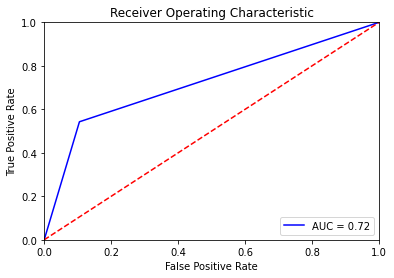

In [26]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_xgb)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Univariate analysis PE/No PE

In [41]:
met_names_df

,CHEM_ID
CHEMICAL_NAME,
S-1-pyrroline-5-carboxylate,35
spermidine,50
1-methylnicotinamide,55
"12,13-DiHOME",62
5-hydroxyindoleacetate,71
...,...
X-26109,999926109
X-26111,999926111
X-26119,999926119


In [77]:
met_df_corr_filt

CHEMICAL_NAME,spermidine,1-methylnicotinamide,"12,13-DiHOME",alpha-ketoglutarate,kynurenate,3-phosphoglycerate,cholate,"5,6-dihydrothymine","9,10-DiHOME",linoleate (18:2n6),...,glycine conjugate of C10H14O2 (1)*,"sphingomyelin (d17:1/14:0, d16:1/15:0)*",6-bromotryptophan,dodecadienoate (12:2)*,N-acetyl-isoputreanine,sulfate of piperine metabolite C16H19NO3 (2)*,sulfate of piperine metabolite C16H19NO3 (3)*,sulfate of piperine metabolite C18H21NO3 (1)*,sulfate of piperine metabolite C18H21NO3 (3)*,pe
BAYL-08997,-0.453404,-0.922809,-0.798951,-0.267786,0.247810,-0.436115,-0.294284,-0.916149,-0.757828,-0.940526,...,-1.078051,-0.220392,-1.364404,-0.970511,-1.501859,-0.863285,-0.790684,-0.800968,-0.626236,1.0
BAYL-08998,-0.744737,0.565122,-0.766087,-0.128899,0.258729,0.535125,0.211342,-0.199096,-0.789683,-0.884868,...,-0.464919,-0.065645,1.003419,-1.415968,-0.747490,-0.344837,-0.311197,-0.370392,-0.290687,1.0
BAYL-08999,-0.372827,-0.792784,3.256302,0.650337,2.198400,0.323468,-0.008444,-0.534364,2.603209,1.675749,...,0.945640,-0.114792,-0.320430,-0.033755,-0.770851,-0.404656,-0.273680,-0.119600,0.699637,0.0
BAYL-09000,-0.443640,0.694152,0.530309,-0.283658,-0.505220,0.005836,-0.252767,-0.434860,0.324271,-0.676082,...,-0.567119,-0.346200,1.615570,-0.764417,-0.579543,-0.734760,-0.722884,-0.996693,-0.819156,0.0
BAYL-09001,-0.364977,-0.708988,-0.651833,0.520338,-0.855289,-0.222898,0.071467,4.166045,-0.713791,0.932884,...,1.408563,0.113013,0.709023,1.158388,-0.642065,0.571862,0.485416,-0.016599,0.606543,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.194081,-0.840516,0.316430,-0.007381,-1.434605,-0.906328,-0.088026,-0.100206,-0.172878,-0.704100,...,-0.176064,0.463684,-0.945826,-1.696028,0.104846,0.312295,0.284862,0.347123,0.241274,0.0
s_23123,-0.577402,0.125697,-0.612133,-0.322195,-0.600495,-0.858999,-0.192598,-1.482526,-0.411120,-0.555800,...,-0.420624,-0.204475,-0.436609,-0.139490,0.084862,-0.415891,-0.504391,-0.216887,-0.327635,0.0
s_22787,0.325477,-1.187554,-1.443000,0.456116,-1.187014,-0.651944,0.027796,-0.107544,-1.488904,-0.834086,...,0.552061,-0.742831,-0.614458,-0.769549,0.668788,-0.239724,-0.156272,-0.029911,-0.120155,0.0
s_23294,-1.132089,0.742540,1.975599,-0.953377,-0.293146,-1.330565,-1.609608,-0.011141,1.538339,-0.412799,...,-0.967641,0.707278,0.758732,-0.269848,0.032913,0.675412,0.711716,0.599729,0.481119,0.0


In [88]:
met_names_df

,CHEM_ID
CHEMICAL_NAME,
S-1-pyrroline-5-carboxylate,35
spermidine,50
1-methylnicotinamide,55
"12,13-DiHOME",62
5-hydroxyindoleacetate,71
...,...
X-26109,999926109
X-26111,999926111
X-26119,999926119


In [94]:
# met_chem_df = met_raw_df.merge(met_names_df, left_index=True, right_index=True)
# met_chem_df.set_index('CHEM_ID', inplace=True)
met_chem_df = met_df_corr_filt.copy()  #met_chem_df.T


met_chem_df = met_chem_df.T.merge(met_names_df, left_index=True, right_index=True)
met_chem_df.set_index('CHEM_ID', inplace=True)
met_chem_df = met_chem_df.T
met_chem_df.loc[:, 'pe'] = clin_filt_df['pe']

print(len(clin_filt_df), len(met_chem_df))

456 456


In [97]:
import scipy.stats as stats
subsets = [{1}, {2}, {3}, {1,2,3}]

with pd.ExcelWriter("ttests.xlsx") as writer:
    for sub in subsets:
        uni_df = met_chem_df.copy()
        uni_df.loc[:, 'ASA'] = clin_filt_df['ASA']
        uni_df = uni_df.loc[clin_filt_df['trimester'].isin(sub), :]
        uni_df = uni_df.loc[uni_df['ASA'] == True, uni_df.columns != 'ASA']
        print(f'Number of samples in {sub} trimester: {len(uni_df)}')
        tstats_df = pd.DataFrame(columns=['Metabolite', 't-statistic', '-log(p-value)', 'delta-z (mean(PE) - mean(NO_PE))', 'mean(NO_PE)', 'mean(PE)']) 
        # Perform the t-test for each column in your DataFrame
        for ind, col in enumerate(uni_df.columns[:-1]):
            dist_no_pe = uni_df.loc[uni_df['pe']==0., col]
            dist_pe = uni_df.loc[uni_df['pe']!=0., col]
            t_stat, p_value = stats.ttest_ind(dist_pe, dist_no_pe)
            if p_value < 0.05:
                tstats_df.loc[ind, :] = [col, t_stat, -np.log(p_value), dist_pe.mean() - dist_no_pe.mean(), dist_no_pe.mean(), dist_pe.mean()]
        tstats_df.sort_values(by='-log(p-value)', inplace=True, ascending=False)
        tstats_df.to_excel(writer, sheet_name=''.join(map(str, sub)) + '_trimester', index=False)


Number of samples in {1} trimester: 52
Number of samples in {2} trimester: 52
Number of samples in {3} trimester: 47
Number of samples in {1, 2, 3} trimester: 151


In [98]:
# Univariate analysis with no aspirin: PE vs no-PE
import scipy.stats as stats
subsets = [{1}, {2}, {3}, {1,2,3}]

with pd.ExcelWriter("ttests_no_asp.xlsx") as writer:
    for sub in subsets:
        uni_no_asp = met_chem_df.copy()
        uni_no_asp.loc[:, 'pe'] = clin_df['pe']
        uni_no_asp = uni_no_asp[(clin_df['trimester'].isin(sub)) & (clin_df['ASA'] == False)]
        
#         uni_df = uni_df.loc[uni_df['ASA'] == True, uni_df.columns != 'ASA']
        print(f'Number of samples in {sub} trimester: {len(uni_no_asp)}')
        tstats_df = pd.DataFrame(columns=['Metabolite', 't-statistic', '-log(p-value)', 'delta-z (mean(PE) - mean(NO_PE))', 'mean(NO_PE)', 'mean(PE)']) 
        # Perform the t-test for each column in your DataFrame
        for ind, col in enumerate(uni_no_asp.columns[:-1]):
            dist_no_pe = uni_no_asp.loc[uni_no_asp['pe']==0., col]
            dist_pe = uni_no_asp.loc[uni_no_asp['pe']!=0., col]
            t_stat, p_value = stats.ttest_ind(dist_pe, dist_no_pe)
            if p_value < 0.05:
                tstats_df.loc[ind, :] = [col, t_stat, -np.log(p_value), dist_pe.mean() - dist_no_pe.mean(), dist_no_pe.mean(), dist_pe.mean()]
        tstats_df.sort_values(by='-log(p-value)', inplace=True, ascending=False)
        tstats_df.to_excel(writer, sheet_name=''.join(map(str, sub)) + '_trimester', index=False)


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_61823/2200865452.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uni_no_asp = uni_no_asp[(clin_df['trimester'].isin(sub)) & (clin_df['ASA'] == False)]


Number of samples in {1} trimester: 73


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_61823/2200865452.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uni_no_asp = uni_no_asp[(clin_df['trimester'].isin(sub)) & (clin_df['ASA'] == False)]
/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_61823/2200865452.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uni_no_asp = uni_no_asp[(clin_df['trimester'].isin(sub)) & (clin_df['ASA'] == False)]


Number of samples in {2} trimester: 86
Number of samples in {3} trimester: 146


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_61823/2200865452.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  uni_no_asp = uni_no_asp[(clin_df['trimester'].isin(sub)) & (clin_df['ASA'] == False)]


Number of samples in {1, 2, 3} trimester: 305
